In [1]:
# Load dependencies/packages
import numpy as np # for array operations
import pandas as pd # for neat tables, database-like grouping/summary tables & csv_read
import matplotlib.pyplot as plt # for the occasional plot
import seaborn as sns # for the occasional plot
sns.set_theme(style="whitegrid")

# for variable selection investigation, use correlation from pandas and stepwise linear regression
import statsmodels.api as sm # to help create Stepwise AIC Linear Regression
import random # for random selection of starting variables/features/predictors

### Classification Model Architectures ###
from sklearn.model_selection import train_test_split, GridSearchCV # train / test split method & Grid Search cross validation
from sklearn.metrics import ConfusionMatrixDisplay
from multiprocessing import cpu_count

# baseline methods
from sklearn.linear_model import LogisticRegression 
# (1) Logistic Regression with ElasticNet penalty, parameter to tune: 'L1 ratio (Lasso) vs. L2 ratio (Ridge)'
from sklearn.neighbors import KNeighborsClassifier # (2) KNN, parameter to tune: 'k neighbors'

# ensemble methods
from sklearn.ensemble import RandomForestClassifier 
# (3) Random Forest (classification) split by 'gini', parameter to tune: ... 
# ... 'max depth' i.e. extent of how much the are individual trees grown AND 'n_estimators'
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
# (4) Boosting (classification), parameter to tune: 'learning rate' AND 'n_estimators'
 
# PCA scaling, transformation
from sklearn.pipeline import make_pipeline # the create a pipeline of transforms necessary to undertake PCA Regression
from sklearn.preprocessing import StandardScaler # first, scale all data as required for PCA
from sklearn.decomposition import PCA # second, perform PCA and take k principal directions of the new linear transformation of X
# then finally use KNN

# Ignore convergence warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)

In [2]:
# Method to append to dict
def add_to_dict(dict_, key, value):
    if key not in dict_:
        dict_[key] = []
    dict_[key].append(value)
    
# alternatively, I could have used *from collections import defaultdict*

In [3]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [4]:
# Load Data - ctop data set
model_data = pd.read_csv('data/out_barc_ctop_6mth_ave.csv') # load data

In [5]:
model_data

,sexo_dummy_var_male,sexo_dummy_var_female,sexo_dummy_var_nan,age,ind_nuevo,antiguedad,indext,ind_actividad_cliente,renta,renta_dummy_var_nan,segmento_dummy_var_01,segmento_dummy_var_02,segmento_dummy_var_03,segmento_dummy_var_nan,ind_ctop_fin_ult1
0,0,1,0,57.500000,0,251.500000,0,1,215210.22,0,0,1,0,0,0
1,1,0,0,47.500000,0,251.500000,0,1,150173.73,0,0,1,0,0,0
2,0,1,0,69.166667,0,251.500000,0,0,576561.87,0,0,1,0,0,0
3,1,0,0,68.000000,0,251.500000,0,1,195763.32,0,1,0,0,0,0
4,1,0,0,67.000000,0,251.166667,0,1,533919.99,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88025,0,1,0,28.000000,1,0.000000,1,0,0.00,1,0,0,0,1,0
88026,0,1,0,51.000000,1,0.000000,0,0,0.00,1,0,0,0,1,0
88027,1,0,0,44.000000,1,0.000000,0,0,0.00,1,0,0,0,1,0
88028,0,1,0,54.000000,1,0.000000,0,0,0.00,1,0,0,0,1,0


In [6]:
# 0-1 Scaling for float/int data
model_data['age'] = normalize_data(model_data['age']) # cast to 0-1 scale
model_data['antiguedad'] = normalize_data(model_data['antiguedad']) # cast to 0-1 scale
model_data['renta'] = normalize_data(model_data['renta']) # cast to 0-1 scale_da

In [7]:
model_data.dtypes

sexo_dummy_var_male         int64
sexo_dummy_var_female       int64
sexo_dummy_var_nan          int64
age                       float64
ind_nuevo                   int64
antiguedad                float64
indext                      int64
ind_actividad_cliente       int64
renta                     float64
renta_dummy_var_nan         int64
segmento_dummy_var_01       int64
segmento_dummy_var_02       int64
segmento_dummy_var_03       int64
segmento_dummy_var_nan      int64
ind_ctop_fin_ult1           int64
dtype: object

In [8]:
model_data.isnull().values.any() # False

False

In [9]:
model_data.describe()

,sexo_dummy_var_male,sexo_dummy_var_female,sexo_dummy_var_nan,age,ind_nuevo,antiguedad,indext,ind_actividad_cliente,renta,renta_dummy_var_nan,segmento_dummy_var_01,segmento_dummy_var_02,segmento_dummy_var_03,segmento_dummy_var_nan,ind_ctop_fin_ult1
count,88030.000000,88030.000000,88030.0,88030.000000,88030.000000,88030.000000,88030.000000,88030.000000,88030.000000,88030.000000,88030.000000,88030.000000,88030.000000,88030.000000,88030.000000
mean,0.430830,0.569181,0.0,0.232324,0.138294,0.307813,0.065909,0.373736,0.023263,0.186402,0.030296,0.578235,0.396717,0.040770,0.092980
std,0.495195,0.495194,0.0,0.104887,0.345210,0.272489,0.248125,0.483798,0.026141,0.389433,0.171403,0.493844,0.489219,0.197759,0.290406
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.136364,0.000000,0.077504,0.000000,0.000000,0.010920,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.0,0.223140,0.000000,0.180843,0.000000,0.000000,0.019502,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.0,0.297521,0.000000,0.522655,0.000000,1.000000,0.029701,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
train_ratio = 0.8
train_size = int(train_ratio*len(model_data.index))

# shuffle dataset
shuffle_model_data = model_data.sample(frac=1)

# train / test split
train_model_data = shuffle_model_data[:train_size]
test_model_data = shuffle_model_data[train_size:]

In [11]:
n_test = len(test_model_data)

In [12]:
train_model_data

,sexo_dummy_var_male,sexo_dummy_var_female,sexo_dummy_var_nan,age,ind_nuevo,antiguedad,indext,ind_actividad_cliente,renta,renta_dummy_var_nan,segmento_dummy_var_01,segmento_dummy_var_02,segmento_dummy_var_03,segmento_dummy_var_nan,ind_ctop_fin_ult1
31953,0,1,0,0.359504,0,0.387520,0,1,0.034351,0,0,1,0,0,0
72926,1,0,0,0.202479,0,0.061606,0,0,0.000000,1,0,1,0,0,0
79575,1,0,0,0.115702,1,0.025835,0,0,0.026570,0,0,0,1,0,0
42486,0,1,0,0.161157,0,0.204690,0,0,0.060068,0,0,0,1,0,0
27089,0,1,0,0.262397,0,0.455087,1,0,0.000000,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61896,0,1,0,0.123967,0,0.117250,0,0,0.010208,0,0,0,1,0,0
52297,1,0,0,0.142562,0,0.156995,0,0,0.000000,1,0,0,1,0,0
70314,0,1,0,0.240702,0,0.073529,0,0,0.009832,0,0,1,0,0,0
59002,1,0,0,0.130165,0,0.121224,0,1,0.029980,0,0,0,1,0,0


In [13]:
test_model_data

,sexo_dummy_var_male,sexo_dummy_var_female,sexo_dummy_var_nan,age,ind_nuevo,antiguedad,indext,ind_actividad_cliente,renta,renta_dummy_var_nan,segmento_dummy_var_01,segmento_dummy_var_02,segmento_dummy_var_03,segmento_dummy_var_nan,ind_ctop_fin_ult1
36820,1,0,0,0.359504,0,0.276232,0,0,0.019851,0,0,1,0,0,0
53298,0,1,0,0.205579,0,0.153021,0,0,0.024644,0,0,1,0,0,0
27007,1,0,0,0.285124,0,0.459062,0,1,0.016822,0,0,1,0,0,0
65405,1,0,0,0.360537,0,0.093402,0,1,0.010878,0,1,1,0,0,0
55581,1,0,0,0.136364,0,0.145072,0,0,0.030398,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48761,1,0,0,0.130165,0,0.167594,0,1,0.011452,0,0,0,1,0,0
81729,1,0,0,0.136364,1,0.021860,0,1,0.000000,1,0,0,1,0,0
40145,1,0,0,0.150826,0,0.212639,0,1,0.008397,0,0,0,1,0,0
71824,1,0,0,0.257231,0,0.069555,0,0,0.009543,0,0,1,0,0,0


In [14]:
# Linear regression with variables (stepwise) selected using AIC
def stepw_reg_mod(n_test, train_data, test_data, k_names, label):
    
    k_start_vars = 0; 
    current_vars = random.sample(k_names, k_start_vars) # this works with k=0

    # Initialize
    # OLS(Y,X + C'), Y-label is first, X-data is last. Need to assign a column of 1's to allow for intercept
    current_stepw_reg = sm.OLS(train_data[label], train_data[current_vars].assign(intercept=1)).fit() 
    current_aic = current_stepw_reg.aic

    step = 0
    max_steps = 50

    #best_forward_vars = current_vars[:]

    while step < max_steps:
        print('current vars:', current_vars)
        print('current AIC:', current_aic)

        ### Forward Step, try adding vars one at a time that improve AIC ###
        print('--- forward step', step, '---')
        best_forward_aic = 10000000 # initialize a dummy var for inner loop of forward step

        # 1. Get the list of potential vars to add
        potential_vars = k_names[:]
        for i in current_vars:
            potential_vars.remove(i) # get the full list and remove those in the model

        # 2. For each potential var, create a model and measure its AIC
        for var in potential_vars:
            forward_vars = current_vars[:]
            forward_vars.append(var)
            forward_stepw_reg = sm.OLS(train_data[label], train_data[forward_vars].assign(intercept=1)).fit()
            forward_aic = forward_stepw_reg.aic

            # 3. Store the potential var with the best AIC performance, and assoc. model, AIC and all model vars
            if forward_aic <= best_forward_aic:
                best_forward_var_to_add = var
                best_forward_vars = forward_vars[:]
                best_forward_aic = forward_aic
                best_forward_stepw_reg = forward_stepw_reg

        print('new var to add:', best_forward_var_to_add)
        print('new vars (forward):', best_forward_vars)
        print('new AIC (forward):', best_forward_aic)
        print('----------------------')

        ### Backwards Step ###
        # 1. Delete the var with the highest p-value > 0.05 signif level, from the current model
        # 2. Rebuild the model with the var deleted

        print('--- backward step', step, '---')
        backward_aic = 10000000 # initialize a dummy var for inner loop of backward step

        current_pvalues = current_stepw_reg.pvalues[:-1] # remove intercept from p signif test
        print('current p values:')
        print(current_pvalues)
        
        if np.max(current_pvalues) > 0.05:

            current_highest_p_var = current_pvalues.index[np.argmax(current_pvalues)]

            print('current var to remove:', current_highest_p_var)
            backward_vars = current_vars[:] # copy current_vars list because remove affects the original list due to pointers
            backward_vars.remove(current_highest_p_var)
            print('new vars (backward):', backward_vars)
            backward_stepw_reg = sm.OLS(train_data[label], train_data[backward_vars].assign(intercept=1)).fit()
            print(backward_stepw_reg.pvalues[:-1])
            backward_aic = backward_stepw_reg.aic
            print('new AIC (backward):', backward_aic)
            print("-----------------------")

        ### Model Selection for Step ###    
        if best_forward_aic < current_aic and best_forward_aic < backward_aic:
            print('****chose forward step****')
            print('')
            current_vars = best_forward_vars[:] # copy current_var list because remove affects the original list due to pointers
            current_aic = best_forward_aic
            current_stepw_reg = best_forward_stepw_reg # save the entire model for prediction and testing analysis

        elif backward_aic < current_aic and backward_aic < best_forward_aic:
            print('****chose backward step****')
            print('')
            current_vars = backward_vars[:] # copy backward_vars list because remove affects the original list due to pointers
            current_aic = backward_aic
            current_stepw_reg = backward_stepw_reg # save the entire model for prediction and testing analysis

        else:
            print('****current model has best performance****')
            break

        step += 1
 
    final_stepw_reg = current_stepw_reg

    stepw_reg_pred_test = final_stepw_reg.predict(test_data[current_vars].assign(intercept=1))
    stepw_reg_test_error = (1/n_test)*np.sum(test_data[label] - stepw_reg_pred_test)**2
    print('')
    print('test error:', stepw_reg_test_error)
    print(final_stepw_reg.params)
    
    return final_stepw_reg

In [15]:
pred_var_names = ['sexo_dummy_var_male', 'sexo_dummy_var_female', 'sexo_dummy_var_nan', 
                  'age', 'ind_nuevo', 'antiguedad', 'indext', 'ind_actividad_cliente', 
                  'renta', 'renta_dummy_var_nan', 'segmento_dummy_var_01', 'segmento_dummy_var_02',
                  'segmento_dummy_var_03', 'segmento_dummy_var_nan' ]

# response_var_names = ['ind_cco_fin_ult1', 'ind_ctop_fin_ult1', 'ind_recibo_ult1']

In [16]:
stepw_reg_mod(n_test, train_model_data, test_model_data, pred_var_names, 'ind_ctop_fin_ult1')

current vars: []
current AIC: 25322.861050446125
--- forward step 0 ---
new var to add: antiguedad
new vars (forward): ['antiguedad']
new AIC (forward): 12117.368328794735
----------------------
--- backward step 0 ---
current p values:
Series([], dtype: float64)
****chose forward step****

current vars: ['antiguedad']
current AIC: 12117.368328794735
--- forward step 1 ---
new var to add: ind_actividad_cliente
new vars (forward): ['antiguedad', 'ind_actividad_cliente']
new AIC (forward): 10351.899124410571
----------------------
--- backward step 1 ---
current p values:
antiguedad    0.0
dtype: float64
****chose forward step****

current vars: ['antiguedad', 'ind_actividad_cliente']
current AIC: 10351.899124410571
--- forward step 2 ---
new var to add: ind_nuevo
new vars (forward): ['antiguedad', 'ind_actividad_cliente', 'ind_nuevo']
new AIC (forward): 10199.631082135587
----------------------
--- backward step 2 ---
current p values:
antiguedad               0.0
ind_actividad_cliente 

In [17]:
# selected predictor variables
stepwise_sel_pred_vars = ['antiguedad', 'ind_actividad_cliente', 'ind_nuevo', 'age', 'segmento_dummy_var_03', 
                          'segmento_dummy_var_01', 'sexo_dummy_var_female', 'renta', 'renta_dummy_var_nan']

# it does not make sense to eliminate dummy variables from the same categorical variable...
# ... therefore, the final selected variables should be:
final_sel_pred_vars = ['sexo_dummy_var_male', 'sexo_dummy_var_female', 'sexo_dummy_var_nan', 
                       'age', 'ind_nuevo', 'antiguedad', 'indext', 'ind_actividad_cliente', 'renta', 'renta_dummy_var_nan', 
                       'segmento_dummy_var_01', 'segmento_dummy_var_02', 'segmento_dummy_var_03', 'segmento_dummy_var_nan']

# i.e keep all variables

In [18]:
# Split into X and y train and test

In [19]:
X_train = train_model_data.drop(columns='ind_ctop_fin_ult1')
y_train = train_model_data['ind_ctop_fin_ult1']
X_test = test_model_data.drop(columns='ind_ctop_fin_ult1')
y_test = test_model_data['ind_ctop_fin_ult1']

In [20]:
# Logistic Regression, KNN, CART, Random Forest, AdaBoost

In [21]:
# Logistic Regression
param_grid = {
    "l1_ratio": [0, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 1],
}

logit_model = GridSearchCV(estimator=LogisticRegression(penalty='elasticnet', solver='saga', max_iter=500),
                        param_grid=param_grid,
                        scoring='accuracy', cv=5,
                        n_jobs=cpu_count(), refit=True)
logit_model.fit(X_train, y_train)
print(logit_model.best_params_)

{'l1_ratio': 1}


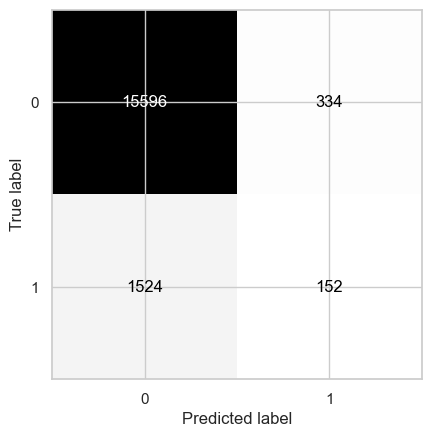

In [22]:
ConfusionMatrixDisplay.from_estimator(logit_model, X_test, y_test,
    display_labels=["0", "1"], cmap="Greys", colorbar=False)

In [23]:
logit_model.score(X_test, y_test)

0.8944677950698625

In [24]:
# KNN
param_grid = {
    "n_neighbors": np.arange(start=3, stop=25, step=2),
}

knn_model = GridSearchCV(estimator=KNeighborsClassifier(metric="hamming"),
                      param_grid=param_grid,
                      scoring='accuracy', cv = 5,
                      n_jobs=cpu_count(), refit = True)
knn_model.fit(X_train, y_train)
print(knn_model.best_params_)

{'n_neighbors': 23}


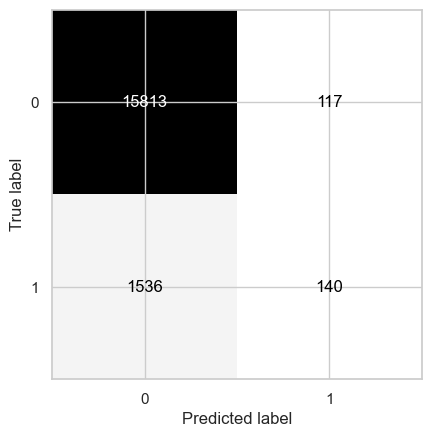

In [25]:
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test,
    display_labels=["0", "1"], cmap="Greys", colorbar=False)

In [26]:
knn_model.score(X_test, y_test)

0.9061115528797001

In [27]:
# Random Forest
param_grid = {
    "n_estimators": [50, 100, 150, 200, 250],
    "max_depth": [2, 3, 4, 5, 6],
    "max_features": ['sqrt']
}

randfor_model = GridSearchCV(estimator=RandomForestClassifier(),
                        param_grid=param_grid,
                        scoring='accuracy', cv=5,
                        n_jobs=cpu_count(), refit=True)
randfor_model.fit(X_train, y_train)
print(randfor_model.best_params_)

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 150}


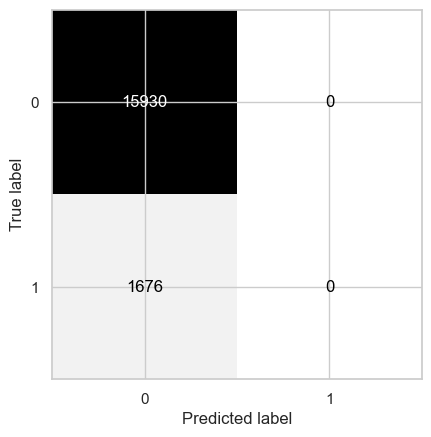

In [28]:
ConfusionMatrixDisplay.from_estimator(randfor_model, X_test, y_test,
    display_labels=["0", "1"], cmap="Greys", colorbar=False)

In [29]:
randfor_model.score(X_test, y_test)

0.904805180052255

In [30]:
# AdaBoost
param_grid = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.1,0.25,0.5],
}

adaboost_model = GridSearchCV(estimator=AdaBoostClassifier(),
                        param_grid=param_grid,
                        scoring='accuracy', cv=5,
                        n_jobs=cpu_count(), refit=True)
adaboost_model.fit(X_train, y_train)
print(adaboost_model.best_params_)

{'learning_rate': 0.1, 'n_estimators': 500}


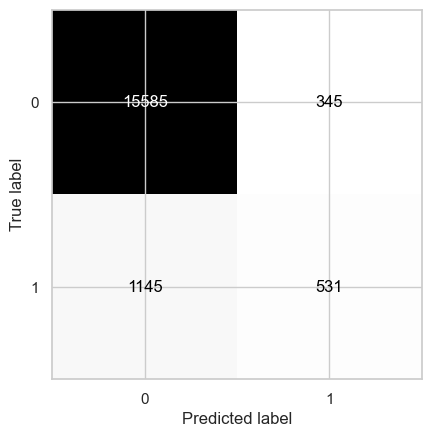

In [31]:
ConfusionMatrixDisplay.from_estimator(adaboost_model, X_test, y_test,
    display_labels=["0", "1"], cmap="Greys", colorbar=False)

In [32]:
adaboost_model.score(X_test, y_test)

0.9153697603089855

In [33]:
# GradientBoost
param_grid = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.1,0.25,0.5],
}

gradboost_model = GridSearchCV(estimator=GradientBoostingClassifier(),
                        param_grid=param_grid,
                        scoring='accuracy', cv=5,
                        n_jobs=cpu_count(), refit=True)
gradboost_model.fit(X_train, y_train)
print(gradboost_model.best_params_)

{'learning_rate': 0.1, 'n_estimators': 100}


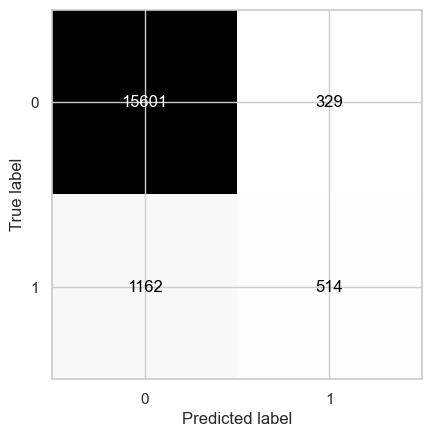

In [34]:
ConfusionMatrixDisplay.from_estimator(gradboost_model, X_test, y_test,
    display_labels=["0", "1"], cmap="Greys", colorbar=False)

In [35]:
gradboost_model.score(X_test, y_test)

0.915312961490401

In [36]:
### Visualization of Decision Boundaries in PC-2 Space ###
pc2_pipeline = make_pipeline(StandardScaler(), PCA(n_components=2))

pred_var_names = final_sel_pred_vars #pred vars for PCA 2 are the final selected pred vars

pc2_pipeline.fit(model_data[pred_var_names]) # fit PCA n=2 to whole data set

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2))])

In [37]:
# project into 2 PCs for data visualization
pc12_model_data = pd.DataFrame(pc2_pipeline.transform(model_data[pred_var_names]),
                              columns = ['pc1', 'pc2']) 
pc12_model_data = pc12_model_data.join(model_data)

In [38]:
pc12_model_data

,pc1,pc2,sexo_dummy_var_male,sexo_dummy_var_female,sexo_dummy_var_nan,age,ind_nuevo,antiguedad,indext,ind_actividad_cliente,renta,renta_dummy_var_nan,segmento_dummy_var_01,segmento_dummy_var_02,segmento_dummy_var_03,segmento_dummy_var_nan,ind_ctop_fin_ult1
0,3.027487,0.136000,0,1,0,0.344008,0,0.999603,0,1,0.037413,0,0,1,0,0,0
1,1.851133,1.181132,1,0,0,0.282025,0,0.999603,0,1,0.026107,0,0,1,0,0,0
2,3.257565,1.204919,0,1,0,0.416322,0,0.999603,0,0,0.100232,0,0,1,0,0,0
3,1.889830,1.105621,1,0,0,0.409091,0,0.999603,0,1,0.034032,0,1,0,0,0,0
4,2.531610,2.030432,1,0,0,0.402893,0,0.998278,0,1,0.092819,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88025,-1.975595,-5.480545,0,1,0,0.161157,1,0.000000,1,0,0.000000,1,0,0,0,1,0
88026,-1.350688,-5.262832,0,1,0,0.303719,1,0.000000,0,0,0.000000,1,0,0,0,1,0
88027,-2.419398,-4.072911,1,0,0,0.260331,1,0.000000,0,0,0.000000,1,0,0,0,1,0
88028,-1.271686,-5.270227,0,1,0,0.322314,1,0.000000,0,0,0.000000,1,0,0,0,1,0


In [39]:
# PC1, age: older -> positive direction, customer seniority: older -> positive direction, ...
# ... segmento: university graduate <--> regular customer
# PC2, household income: higher -> positive direction

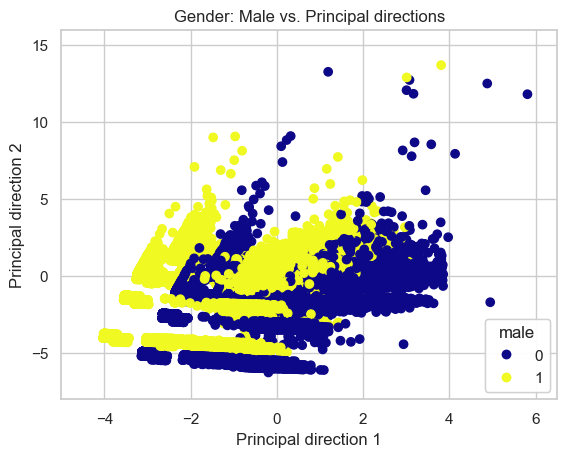

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-5, 6.5), ylim=(-8, 16))
scatter = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['sexo_dummy_var_male'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title="male")
ax1.add_artist(legend1)
plt.title('Gender: Male vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

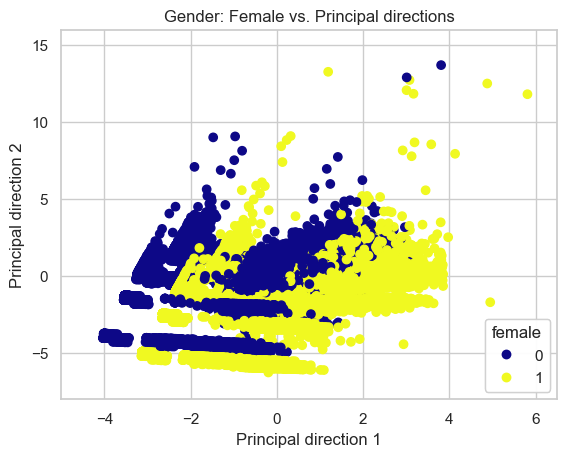

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-5, 6.5), ylim=(-8, 16))
scatter = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['sexo_dummy_var_female'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title="female")
ax1.add_artist(legend1)
plt.title('Gender: Female vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

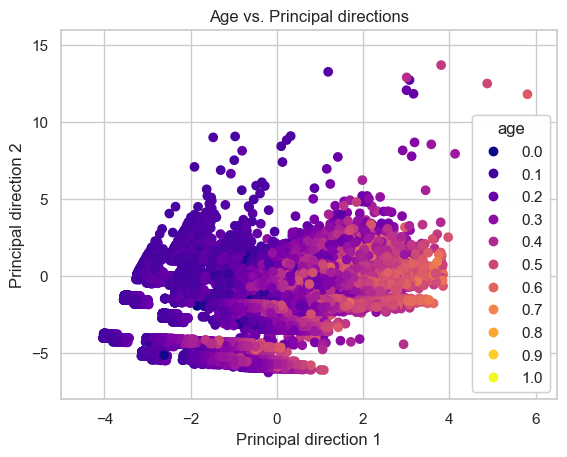

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-5, 6.5), ylim=(-8, 16))
scatter = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['age'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title="age")
ax1.add_artist(legend1)
plt.title('Age vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

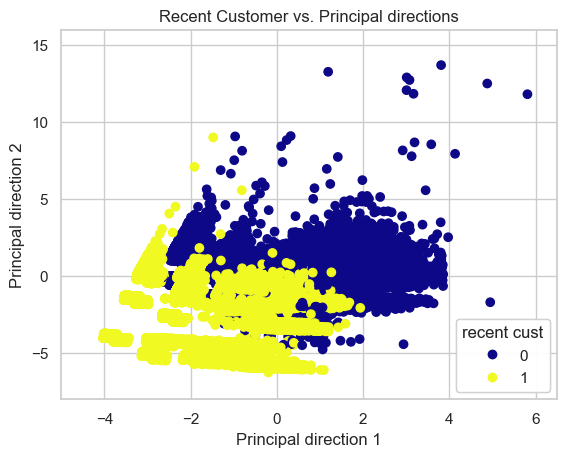

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-5, 6.5), ylim=(-8, 16))
scatter = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['ind_nuevo'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title="recent cust")
ax1.add_artist(legend1)
plt.title('Recent Customer vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

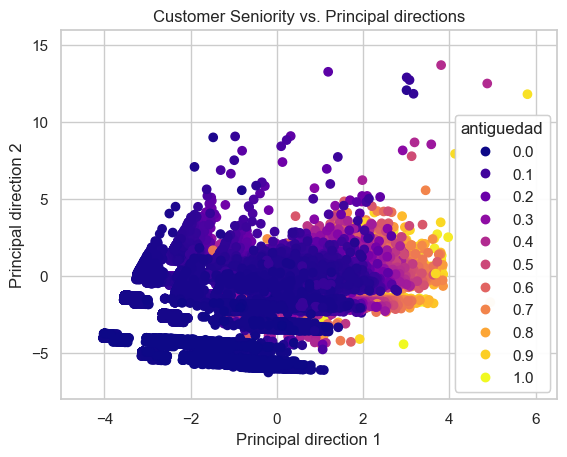

In [44]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-5, 6.5), ylim=(-8, 16))
scatter = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['antiguedad'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title="antiguedad")
ax1.add_artist(legend1)
plt.title('Customer Seniority vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

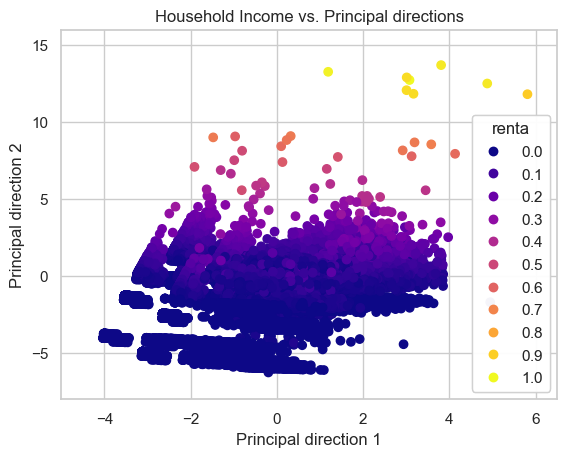

In [45]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-5, 6.5), ylim=(-8, 16))
scatter = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['renta'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title='renta')
ax1.add_artist(legend1)
plt.title('Household Income vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

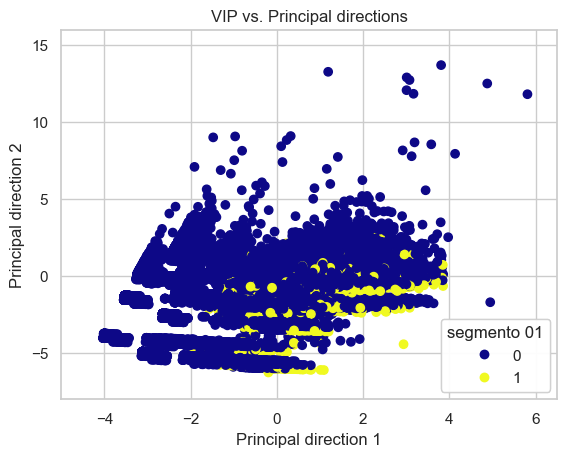

In [46]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-5, 6.5), ylim=(-8, 16))
scatter = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['segmento_dummy_var_01'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title='segmento 01')
ax1.add_artist(legend1)
plt.title('VIP vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

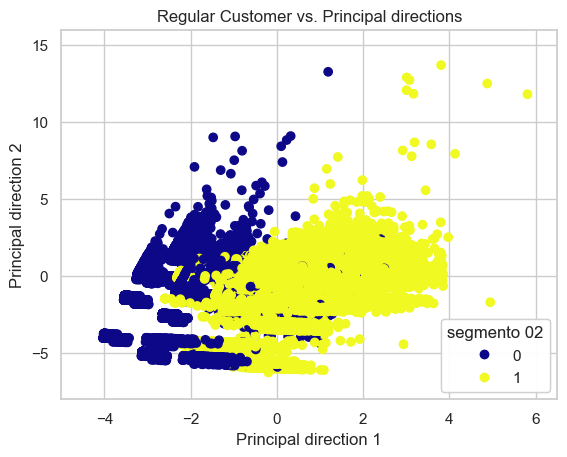

In [47]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-5, 6.5), ylim=(-8, 16))
scatter = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['segmento_dummy_var_02'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title='segmento 02')
ax1.add_artist(legend1)
plt.title('Regular Customer vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

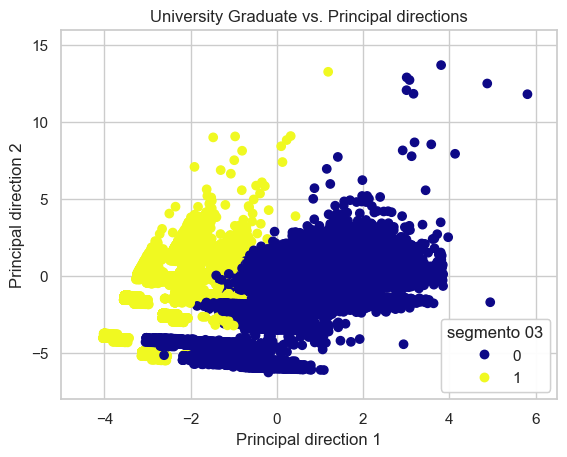

In [48]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-5, 6.5), ylim=(-8, 16))
scatter = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['segmento_dummy_var_03'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title='segmento 03')
ax1.add_artist(legend1)
plt.title('University Graduate vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

In [49]:
# Create a grid over the 2D plot axes domain
grid1 = np.linspace(-5,6.5,num=100)
grid2 = np.linspace(-8,16,num=100)
grid_list = []
for x in grid1:
    for y in grid2:
        grid_list.append([x, y])
        
grid = pd.DataFrame(grid_list, columns=['pc1', 'pc2'])

In [50]:
# Reduce pc12 dataset to pc1, pc2 and label
pc12_X_train, pc12_X_test, pc12_y_train, pc12_y_test = train_test_split(
    pc12_model_data[['pc1', 'pc2']], pc12_model_data['ind_ctop_fin_ult1'], test_size = 0.8, random_state=55)

In [55]:
# Re-specify model architectures

# best parameters
#best_shrinkage = 0
best_l1_ratio = 1
best_k = 23
#best_depth_cart = 5
best_n_trees = 150
best_depth_rf = 6
best_max_features = 'sqrt'
best_n_estimators_ab = 500
best_learn_rate_ab = 0.1
best_n_estimators_gb = 100
best_learn_rate_gb = 0.1

#lda_0 = LinearDiscriminantAnalysis(solver='eigen', shrinkage=best_shrinkage)
logit_0 = LogisticRegression(penalty='elasticnet', solver='saga',
                                 max_iter=500, l1_ratio=best_l1_ratio)
knn_0 = KNeighborsClassifier(n_neighbors=best_k)
#cart_0 = tree.DecisionTreeClassifier(max_depth=best_depth_cart)
rforest_0 = RandomForestClassifier(n_estimators=best_n_trees, max_depth=best_depth_rf, max_features='sqrt', random_state=0)
adaboost_0 = AdaBoostClassifier(n_estimators=best_n_estimators_ab, learning_rate = best_learn_rate_ab, random_state=0)
gradboost_0 = GradientBoostingClassifier(n_estimators=best_n_estimators_gb, learning_rate = best_learn_rate_gb, random_state=0)

# Calculate/predict grid 'mpg01' labels for various models re-trained on PC2 data
#grid['lda'] = lda_0.fit(pc2_X_train, y_train).predict(grid.iloc[:,:2])
grid['logit'] = logit_0.fit(pc12_X_train, pc12_y_train).predict(grid.iloc[:,:2])
grid['knn'] = knn_0.fit(pc12_X_train, pc12_y_train).predict(grid.iloc[:,:2])
#grid['cart'] = cart_0.fit(pc12_X_train, y_train).predict(grid.iloc[:,:2])
grid['rforest'] = rforest_0.fit(pc12_X_train, pc12_y_train).predict(grid.iloc[:,:2])
grid['adaboost'] = adaboost_0.fit(pc12_X_train, pc12_y_train).predict(grid.iloc[:,:2])
grid['gradboost'] = gradboost_0.fit(pc12_X_train, pc12_y_train).predict(grid.iloc[:,:2])

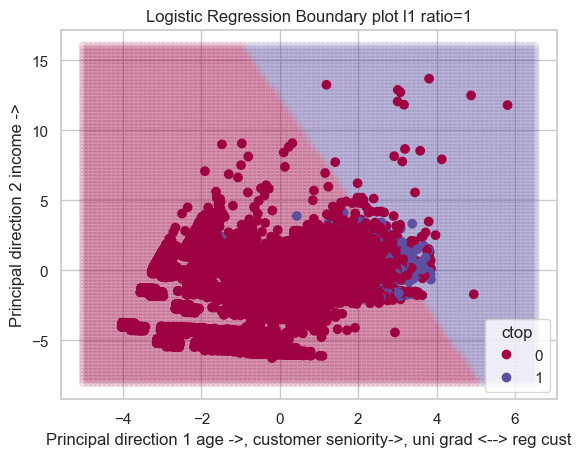

In [62]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['logit'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['ind_ctop_fin_ult1'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="ctop")
plt.title('Logistic Regression Boundary plot l1 ratio=1')
plt.xlabel('Principal direction 1 age ->, customer seniority->, uni grad <--> reg cust')
plt.ylabel('Principal direction 2 income ->')
plt.show()

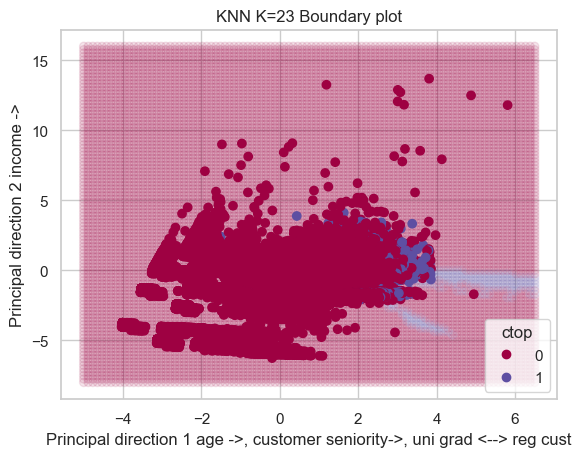

In [57]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['knn'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['ind_ctop_fin_ult1'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="ctop")
plt.title('KNN K=23 Boundary plot')
plt.xlabel('Principal direction 1 age ->, customer seniority->, uni grad <--> reg cust')
plt.ylabel('Principal direction 2 income ->')
plt.show()

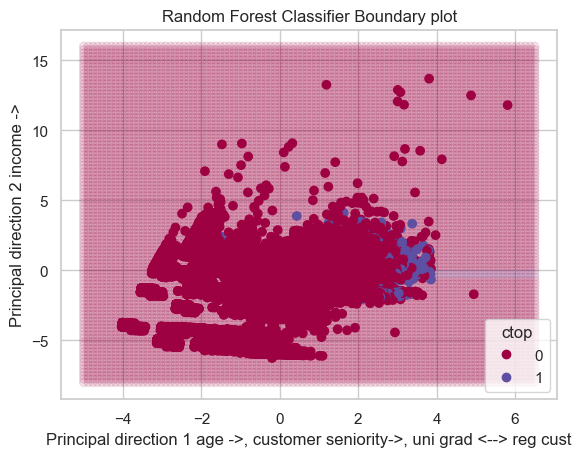

In [58]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['rforest'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['ind_ctop_fin_ult1'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="ctop")
plt.title('Random Forest Classifier Boundary plot')
plt.xlabel('Principal direction 1 age ->, customer seniority->, uni grad <--> reg cust')
plt.ylabel('Principal direction 2 income ->')
plt.show()

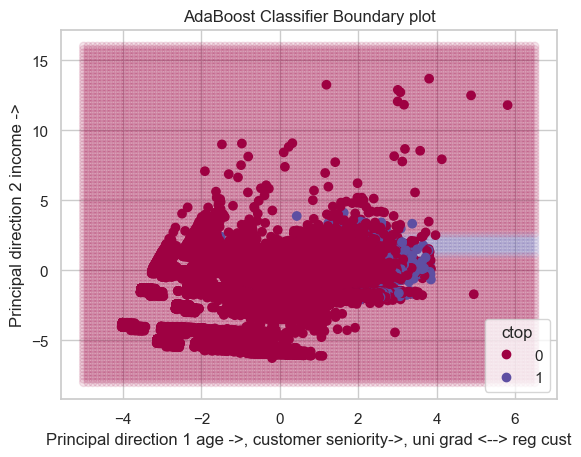

In [59]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['adaboost'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['ind_ctop_fin_ult1'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="ctop")
plt.title('AdaBoost Classifier Boundary plot')
plt.xlabel('Principal direction 1 age ->, customer seniority->, uni grad <--> reg cust')
plt.ylabel('Principal direction 2 income ->')
plt.show()

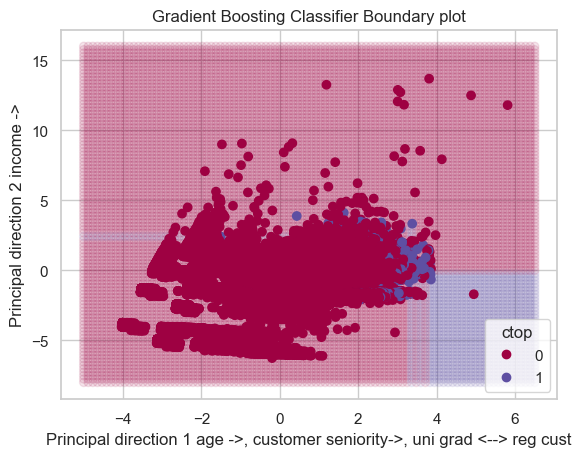

In [61]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['gradboost'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_model_data['pc1'], pc12_model_data['pc2'], c=pc12_model_data['ind_ctop_fin_ult1'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="ctop")
plt.title('Gradient Boosting Classifier Boundary plot')
plt.xlabel('Principal direction 1 age ->, customer seniority->, uni grad <--> reg cust')
plt.ylabel('Principal direction 2 income ->')
plt.show()